# Circos-Style Money Flow Chord Diagram

This notebook builds a **self-contained** Circos-style chord diagram from Accumulation Score time series in a local database.

Constraints honored:
- No project modules are imported or modified.
- Database access is read-only (SELECT-only).
- No files are written or mutated; all outputs are in-notebook only.


In [1]:
# Ticker groups (hardcoded)
SECTOR_CORE_TICKERS = [
    "XLF","KRE","XLK","SMH","XLI","XLY","XLE","XLV","XLP","XLU"
]

GLOBAL_MACRO_TICKERS = [
    "SPY","QQQ","TQQQ","IWM","VGK","EWJ","EFA","EEM","FXI","UUP","TLT","GLD","USO","VIXY"
]

COMMODITIES_TICKERS = [
    "GLD","SLV","GDX","USO","UNG","URA"
]

# Controls
END_DATE = None  # e.g., "2025-12-30"; None = auto-detect max date in DB
WINDOW_DAYS = 5
TOP_K_WINNERS = 8
TOP_K_LOSERS = 8
MIN_EDGE_FLOW = 0.0
DISTRIBUTION_MODE = "demand_weighted"  # "equal" or "demand_weighted"
STRAND_UNIT = 0.5  # controls link strand splitting density


In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

def find_db_candidates():
    root = Path('.').resolve()
    search_dirs = [
        root / 'data',
        root / 'darkpool_analysis' / 'data',
        root,
    ]
    patterns = ['*.duckdb', '*.db', '*.sqlite', '*.sqlite3']
    candidates = []
    for base in search_dirs:
        if not base.exists():
            continue
        for pattern in patterns:
            candidates.extend(list(base.rglob(pattern)))
    # Unique + files only
    unique = []
    seen = set()
    for p in candidates:
        if not p.is_file():
            continue
        if p in seen:
            continue
        seen.add(p)
        unique.append(p)
    unique.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return unique

def connect_db(db_path):
    db_path = Path(db_path)
    suffix = db_path.suffix.lower()
    errors = []

    def try_duckdb():
        import duckdb
        return duckdb.connect(database=str(db_path), read_only=True), 'duckdb'

    def try_sqlite():
        import sqlite3
        uri = f"file:{db_path.resolve().as_posix()}?mode=ro"
        return sqlite3.connect(uri, uri=True), 'sqlite'

    if suffix == '.duckdb':
        try:
            return try_duckdb()
        except Exception as e:
            errors.append(f'duckdb: {e}')
        try:
            return try_sqlite()
        except Exception as e:
            errors.append(f'sqlite: {e}')
    else:
        try:
            return try_sqlite()
        except Exception as e:
            errors.append(f'sqlite: {e}')
        try:
            return try_duckdb()
        except Exception as e:
            errors.append(f'duckdb: {e}')

    raise RuntimeError('Unable to open database. ' + '; '.join(errors))

def list_tables(conn, db_type):
    if db_type == 'duckdb':
        return [r[0] for r in conn.execute('SHOW TABLES').fetchall()]
    rows = conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()
    return [r[0] for r in rows]

def get_columns(conn, db_type, table):
    pragma = f'PRAGMA table_info("{table}")'
    rows = conn.execute(pragma).fetchall()
    # rows: (cid, name, type, notnull, dflt_value, pk)
    return [r[1] for r in rows]

def normalize_name(name):
    return ''.join([c for c in name.lower() if c.isalnum()])

def pick_column(columns, candidates):
    norm_map = {normalize_name(c): c for c in columns}
    for cand in candidates:
        cand_norm = normalize_name(cand)
        if cand_norm in norm_map:
            return norm_map[cand_norm]
    for cand in candidates:
        cand_norm = normalize_name(cand)
        for col_norm, original in norm_map.items():
            if cand_norm in col_norm:
                return original
    return None

def quote_ident(name):
    safe = name.replace('"', '""')
    return f'"{safe}"'

TICKER_COL_CANDIDATES = ['ticker', 'symbol', 'sym']
DATE_COL_CANDIDATES = ['date', 'trade_date', 'market_date', 'dt', 'day']
ACCUM_COL_CANDIDATES = [
    'accumulation_score', 'accum_score', 'accumulation', 'accum',
    'accumulation_score_display', 'accum_score_display'
]

db_candidates = find_db_candidates()
print('DB candidates (newest first):')
for p in db_candidates:
    print(' -', p)

if not db_candidates:
    print('No database files found under ./data or ./darkpool_analysis/data.')
    raise SystemExit

DB_PATH = db_candidates[0]
print(f'Selected DB: {DB_PATH}')

conn, DB_TYPE = connect_db(DB_PATH)
print(f'Detected DB type: {DB_TYPE}')

tables = list_tables(conn, DB_TYPE)
print(f'Found {len(tables)} tables.')

scan_rows = []
for table in tables:
    try:
        cols = get_columns(conn, DB_TYPE, table)
    except Exception as e:
        scan_rows.append({
            'table': table,
            'ticker_col': None,
            'date_col': None,
            'accum_col': None,
            'row_count': None,
            'distinct_tickers': None,
            'error': str(e),
        })
        continue

    ticker_col = pick_column(cols, TICKER_COL_CANDIDATES)
    date_col = pick_column(cols, DATE_COL_CANDIDATES)
    accum_col = pick_column(cols, ACCUM_COL_CANDIDATES)

    row_count = None
    distinct_tickers = None
    if ticker_col and date_col and accum_col:
        try:
            row_count = conn.execute(
                f'SELECT COUNT(*) FROM {quote_ident(table)}'
            ).fetchone()[0]
            distinct_tickers = conn.execute(
                f'SELECT COUNT(DISTINCT {quote_ident(ticker_col)}) FROM {quote_ident(table)}'
            ).fetchone()[0]
        except Exception:
            pass

    scan_rows.append({
        'table': table,
        'ticker_col': ticker_col,
        'date_col': date_col,
        'accum_col': accum_col,
        'row_count': row_count,
        'distinct_tickers': distinct_tickers,
        'error': None,
    })

print('Scanned tables (ticker/date/accum detection):')
for row in scan_rows:
    print(
        f" - {row['table']}: ticker={row['ticker_col']} date={row['date_col']} accum={row['accum_col']} rows={row['row_count']} distinct_tickers={row['distinct_tickers']}"
    )

candidates = [r for r in scan_rows if r['ticker_col'] and r['date_col'] and r['accum_col']]
if not candidates:
    print('No tables matched the required ticker/date/accumulation schema.')
    conn.close()
    raise SystemExit

multi = [r for r in candidates if (r['distinct_tickers'] or 0) > 1]
pool = multi if multi else candidates
pool.sort(key=lambda r: (r['row_count'] or 0, r['distinct_tickers'] or 0), reverse=True)
best = pool[0]

SELECT_TABLE = best['table']
TICKER_COL = best['ticker_col']
DATE_COL = best['date_col']
ACCUM_COL = best['accum_col']

print('Selected table:')
print(f'  table={SELECT_TABLE}')
print(f'  ticker_col={TICKER_COL}, date_col={DATE_COL}, accum_col={ACCUM_COL}')

conn.close()


DB candidates (newest first):
 - C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Selected DB: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Detected DB type: duckdb
Found 13 tables.
Scanned tables (ticker/date/accum detection):
 - composite_signal: ticker=symbol date=date accum=None rows=None distinct_tickers=None
 - daily_metrics: ticker=symbol date=date accum=accumulation_score rows=520 distinct_tickers=15
 - finra_otc_weekly_raw: ticker=symbol date=week_start_date accum=None rows=None distinct_tickers=None
 - finra_short_daily_all_raw: ticker=symbol date=trade_date accum=None rows=None distinct_tickers=None
 - finra_short_daily_raw: ticker=symbol date=trade_date accum=None rows=None distinct_tickers=None
 - index_constituent_short_agg_daily: ticker=index_symbol date=trade_date accum=None rows=None distinct_tickers=None
 - lit_direction_daily: ticker=symbol date=date accum=None rows=None distinct_tickers=None
 - options_pr

In [3]:
def build_ticker_universe():
    seen = set()
    ordered = []
    categories = {}
    for t in GLOBAL_MACRO_TICKERS:
        if t not in seen:
            seen.add(t)
            ordered.append(t)
            categories[t] = 'GLOBAL_MACRO'
    for t in SECTOR_CORE_TICKERS:
        if t not in seen:
            seen.add(t)
            ordered.append(t)
            categories[t] = 'SECTOR_CORE'
    for t in COMMODITIES_TICKERS:
        if t not in seen:
            seen.add(t)
            ordered.append(t)
            categories[t] = 'COMMODITIES'
    return ordered, categories

ticker_order, ticker_category = build_ticker_universe()
ticker_list = [t.upper() for t in ticker_order]

conn, DB_TYPE = connect_db(DB_PATH)

if DB_TYPE == 'duckdb':
    date_expr = f"CAST({quote_ident(DATE_COL)} AS DATE)"
    accum_expr = f"TRY_CAST({quote_ident(ACCUM_COL)} AS DOUBLE)"
else:
    date_expr = f"DATE({quote_ident(DATE_COL)})"
    accum_expr = f"CAST({quote_ident(ACCUM_COL)} AS REAL)"

placeholders = ','.join(['?'] * len(ticker_list))
query = (
    f"SELECT UPPER({quote_ident(TICKER_COL)}) AS ticker, "
    f"{date_expr} AS date, {accum_expr} AS accumulation_score "
    f"FROM {quote_ident(SELECT_TABLE)} "
    f"WHERE UPPER({quote_ident(TICKER_COL)}) IN ({placeholders})"
)

try:
    if DB_TYPE == 'duckdb':
        df_raw = conn.execute(query, ticker_list).df()
    else:
        df_raw = pd.read_sql_query(query, conn, params=ticker_list)
finally:
    conn.close()

if df_raw.empty:
    print('No data returned for the specified tickers.')
    raise SystemExit

df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce').dt.date
df_raw['ticker'] = df_raw['ticker'].str.upper()
df_raw['accumulation_score'] = pd.to_numeric(df_raw['accumulation_score'], errors='coerce')
df_raw = df_raw.dropna(subset=['date', 'accumulation_score'])

if df_raw.empty:
    print('All accumulation score rows are null after parsing.')
    raise SystemExit

max_date = df_raw['date'].max()
if END_DATE is None or str(END_DATE).strip() == '':
    END_DATE_RESOLVED = max_date
else:
    END_DATE_RESOLVED = pd.to_datetime(END_DATE).date()
    if END_DATE_RESOLVED > max_date:
        print(f'END_DATE {END_DATE_RESOLVED} exceeds DB max date {max_date}; using max date.')
        END_DATE_RESOLVED = max_date

start_target = END_DATE_RESOLVED - timedelta(days=WINDOW_DAYS)

def value_at_or_before(df_ticker, target_date):
    df_leq = df_ticker[df_ticker['date'] <= target_date]
    if df_leq.empty:
        return None, None
    row = df_leq.iloc[-1]
    return row['date'], row['accumulation_score']

rows = []
for ticker in ticker_order:
    df_t = df_raw[df_raw['ticker'] == ticker].sort_values('date')
    end_date, a_end = value_at_or_before(df_t, END_DATE_RESOLVED)
    start_date, a_start = value_at_or_before(df_t, start_target)
    rows.append({
        'ticker': ticker,
        'category': ticker_category.get(ticker, 'UNKNOWN'),
        'A_end': a_end,
        'A_start': a_start,
        'end_date': end_date,
        'start_date': start_date,
    })

df_scores = pd.DataFrame(rows)


In [4]:
df_scores['delta'] = df_scores['A_end'] - df_scores['A_start']
df_scores['role'] = np.where(
    df_scores['delta'] > 0,
    'winner',
    np.where(df_scores['delta'] < 0, 'loser', 'neutral')
)

df_scores_sorted = df_scores.sort_values(
    by='delta', key=lambda s: s.abs(), ascending=False
).reset_index(drop=True)

valid = df_scores.dropna(subset=['delta']).copy()
winners = valid[valid['delta'] > 0].nlargest(TOP_K_WINNERS, 'delta')
losers = valid[valid['delta'] < 0].copy()
losers['supply'] = -losers['delta']
losers = losers.nlargest(TOP_K_LOSERS, 'supply')

edges = []
total_demand = winners['delta'].sum() if not winners.empty else 0.0
total_supply = losers['supply'].sum() if not losers.empty else 0.0

if winners.empty or losers.empty:
    print('No winners or losers found for the selected window. Adjust WINDOW_DAYS or TOP_K settings.')
else:
    if DISTRIBUTION_MODE not in {'equal', 'demand_weighted'}:
        raise ValueError('DISTRIBUTION_MODE must be "equal" or "demand_weighted"')

    if DISTRIBUTION_MODE == 'equal':
        for _, loser in losers.iterrows():
            flow_each = loser['supply'] / len(winners)
            for _, winner in winners.iterrows():
                if flow_each >= MIN_EDGE_FLOW:
                    edges.append({
                        'source': loser['ticker'],
                        'dest': winner['ticker'],
                        'flow': float(flow_each),
                    })
    else:
        if total_demand <= 0:
            print('Total demand is zero; cannot allocate demand-weighted flows.')
        else:
            for _, loser in losers.iterrows():
                for _, winner in winners.iterrows():
                    flow = loser['supply'] * (winner['delta'] / total_demand)
                    if flow >= MIN_EDGE_FLOW:
                        edges.append({
                            'source': loser['ticker'],
                            'dest': winner['ticker'],
                            'flow': float(flow),
                        })

edges_df = pd.DataFrame(edges)
if not edges_df.empty:
    edges_df = edges_df.sort_values('flow', ascending=False).reset_index(drop=True)

strand_rows = []
unit = STRAND_UNIT if STRAND_UNIT and STRAND_UNIT > 0 else None
for _, row in edges_df.iterrows():
    flow = row['flow']
    if unit:
        n = max(1, int(np.floor(flow / unit)))
    else:
        n = 1
    weight = flow / n
    for _ in range(n):
        strand_rows.append({
            'source': row['source'],
            'dest': row['dest'],
            'weight': weight,
        })

strands_df = pd.DataFrame(strand_rows)


In [5]:
display(df_scores_sorted[['ticker', 'category', 'A_end', 'A_start', 'delta', 'role']])

if edges_df.empty:
    display(pd.DataFrame(columns=['source', 'dest', 'flow']))
else:
    display(edges_df[['source', 'dest', 'flow']])

summary = (
    f'END_DATE={END_DATE_RESOLVED}, WINDOW_DAYS={WINDOW_DAYS} | '
    f'total_supply={total_supply:.2f}, total_demand={total_demand:.2f} | '
    f'winners={len(winners)}, losers={len(losers)}, edges={len(edges_df)}, strands={len(strands_df)}'
)
print(summary)


,ticker,category,A_end,A_start,delta,role
0,XLF,SECTOR_CORE,-0.273530,0.534137,-0.807667,loser
1,XLV,SECTOR_CORE,-0.118185,0.406542,-0.524726,loser
2,XLK,SECTOR_CORE,-0.043860,0.418667,-0.462526,loser
3,XLE,SECTOR_CORE,0.081658,0.397419,-0.315760,loser
4,XLY,SECTOR_CORE,0.145657,0.424972,-0.279315,loser
5,XLI,SECTOR_CORE,-0.091644,-0.349678,0.258034,winner
6,XLP,SECTOR_CORE,-0.201892,0.046043,-0.247935,loser
7,KRE,SECTOR_CORE,-0.023423,-0.044109,0.020686,winner
8,SMH,SECTOR_CORE,0.117249,0.100052,0.017197,winner
9,XLU,SECTOR_CORE,0.113680,0.127147,-0.013468,loser


,source,dest,flow
0,XLF,XLI,0.704269
1,XLV,XLI,0.457551
2,XLK,XLI,0.403314
3,XLE,XLI,0.275337
4,XLY,XLI,0.243557
5,XLP,XLI,0.216195
6,XLF,KRE,0.056461
7,XLF,SMH,0.046937
8,XLV,KRE,0.036681
9,XLK,KRE,0.032333


END_DATE=2025-12-30, WINDOW_DAYS=5 | total_supply=2.65, total_demand=0.30 | winners=3, losers=7, edges=21, strands=21


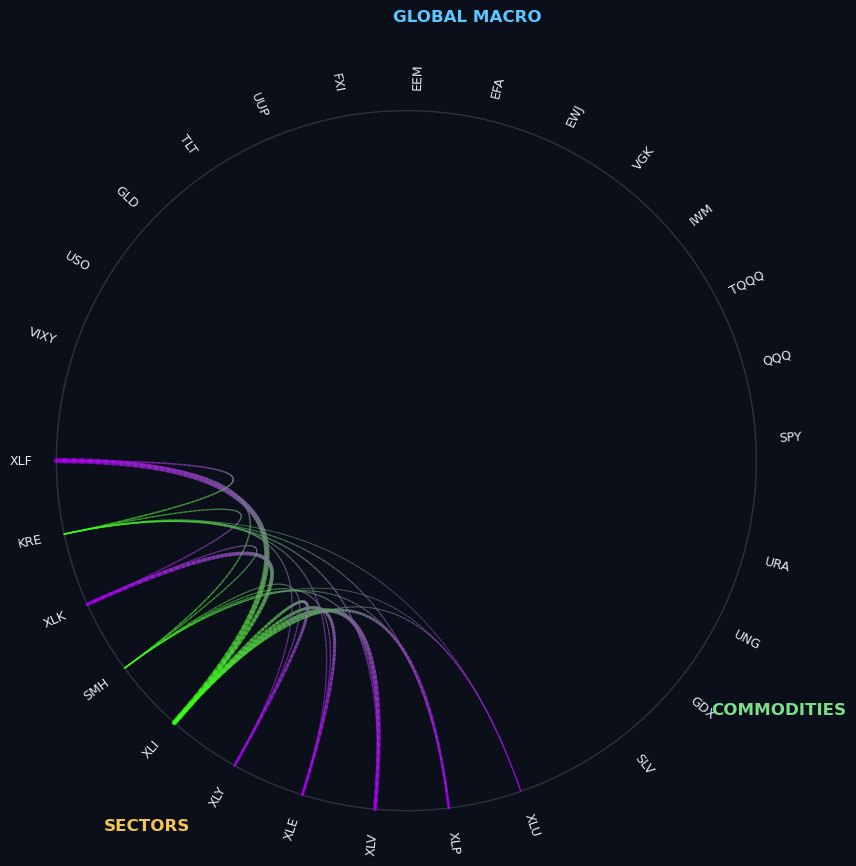

In [6]:
import math
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba

CATEGORY_LABELS = {
    'GLOBAL_MACRO': 'GLOBAL MACRO',
    'SECTOR_CORE': 'SECTORS',
    'COMMODITIES': 'COMMODITIES',
}
CATEGORY_PALETTE = {
    'GLOBAL_MACRO': '#5CC8FF',
    'SECTOR_CORE': '#F6C453',
    'COMMODITIES': '#7CDE8A',
    'UNKNOWN': '#A0A0A0',
}
FLOW_SOURCE_COLOR = '#B300FF'  # neon purple
FLOW_DEST_COLOR = '#39FF14'    # neon green


def add_gradient_curve(ax, points, color_start, color_end, lw, alpha):
    if len(points) < 2:
        return
    segments = np.stack([points[:-1], points[1:]], axis=1)
    c0 = np.array(to_rgba(color_start))
    c1 = np.array(to_rgba(color_end))
    t = np.linspace(0, 1, len(segments))[:, None]
    colors = c0 * (1 - t) + c1 * t
    colors[:, 3] = colors[:, 3] * alpha
    lc = LineCollection(segments, colors=colors, linewidths=lw, capstyle='round')
    ax.add_collection(lc)


def plot_chord_matplotlib(strands_df, ticker_order, ticker_category):
    if strands_df.empty:
        print('No edges to plot.')
        return

    grouped = {
        'GLOBAL_MACRO': [t for t in ticker_order if ticker_category.get(t) == 'GLOBAL_MACRO'],
        'SECTOR_CORE': [t for t in ticker_order if ticker_category.get(t) == 'SECTOR_CORE'],
        'COMMODITIES': [t for t in ticker_order if ticker_category.get(t) == 'COMMODITIES'],
    }

    total_nodes = sum(len(v) for v in grouped.values())
    if total_nodes == 0:
        print('No nodes to plot.')
        return

    gap = 0.12
    total_gap = gap * len(grouped)
    usable = 2 * math.pi - total_gap
    if usable <= 0:
        usable = 2 * math.pi
    step = usable / total_nodes

    angles = {}
    angle = 0.0
    for cat in ['GLOBAL_MACRO', 'SECTOR_CORE', 'COMMODITIES']:
        angle += gap / 2
        for t in grouped[cat]:
            angles[t] = angle
            angle += step
        angle += gap / 2

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})
    fig.patch.set_facecolor('#0b0f1a')
    ax.set_facecolor('#0b0f1a')
    ax.axis('off')

    theta = np.linspace(0, 2 * math.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), color='#39424e', lw=1.0, alpha=0.7)

    max_w = strands_df['weight'].max() if not strands_df.empty else 1.0
    for _, row in strands_df.iterrows():
        src = row['source']
        dst = row['dest']
        w = row['weight']
        if src not in angles or dst not in angles:
            continue
        a0 = angles[src]
        a1 = angles[dst]
        p0 = np.array([math.cos(a0), math.sin(a0)])
        p2 = np.array([math.cos(a1), math.sin(a1)])
        p1 = np.array([0.0, 0.0])
        t = np.linspace(0, 1, 80)[:, None]
        curve = (1 - t) ** 2 * p0 + 2 * (1 - t) * t * p1 + t ** 2 * p2
        lw = 0.6 + 3.2 * ((w / max_w) ** 0.7)
        add_gradient_curve(
            ax,
            curve,
            FLOW_SOURCE_COLOR,
            FLOW_DEST_COLOR,
            lw=lw,
            alpha=0.6,
        )

    for t, ang in angles.items():
        x = math.cos(ang)
        y = math.sin(ang)
        r = 1.10
        rot = math.degrees(ang)
        if math.pi / 2 < ang < 3 * math.pi / 2:
            rot += 180
        ax.text(
            r * x, r * y, t,
            color='#E6EDF7', fontsize=9,
            ha='center', va='center',
            rotation=rot, rotation_mode='anchor'
        )

    for cat, tickers in grouped.items():
        if not tickers:
            continue
        mid_angle = np.mean([angles[t] for t in tickers])
        ax.text(
            1.28 * math.cos(mid_angle),
            1.28 * math.sin(mid_angle),
            CATEGORY_LABELS.get(cat, cat),
            color=CATEGORY_PALETTE.get(cat, '#A0A0A0'),
            fontsize=12, fontweight='bold',
            ha='center', va='center'
        )

    plt.show()


def plot_chord_with_fallback(strands_df, ticker_order, ticker_category):
    plot_chord_matplotlib(strands_df, ticker_order, ticker_category)


plot_chord_with_fallback(strands_df, ticker_order, ticker_category)
